# Manual Feature Engineering on the Retail Dataset

In this notebook we will work on manual feature engineering of a retail dataset. This dataset is originally from the UCI machine learning repository and is reminiscient of real-world data.

In [1]:
import numpy as np
import pandas as pd

import featuretools as ft

First let's load in the raw data and take a look.

In [2]:
csv_s3 = "s3://featurelabs-static/online-retail-logs.csv"
data = pd.read_csv(csv_s3, parse_dates=["order_date"])

# Convert to dollars
data['price'] = data['price'] * 1.65
data['total'] = data['price'] * data['quantity']

# Restrict data to 2011
data = data[data['order_date'].dt.year == 2011]

# drop the duplicates
data = data.drop_duplicates()

# drop rows with null customer id
data = data.dropna(axis=0)

data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Load in Prediction Problem



In [1]:
labels = pd.read_csv('../input/labels.csv')
labels.head()

NameError: name 'pd' is not defined

In [3]:
csv_s3 = "s3://featurelabs-static/online-retail-logs.csv"
altered_data = pd.read_csv(csv_s3, parse_dates=["order_date"])
altered_data.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


First we need to understand what each of the columns represents. For that we can look at the [data description on the UCI Machine Learning Repository.](https://archive.ics.uci.edu/ml/datasets/online+retail#)

* `InvoiceNo`: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
* `StockCode`: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. 
* `Description`: Product (item) name. Nominal. 
* `Quantity`: The quantities of each product (item) per transaction. Numeric.	
* `InvoiceDate`: Invice Date and time. Numeric, the day and time when each transaction was generated. 
* `UnitPrice`: Unit price. Numeric, Product price per unit in sterling. 
* `CustomerID`: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. 
* `Country`: Country name. Nominal, the name of the country where each customer resides.

Based on these descriptions, we will rename the columns so they are easier to remember.

In [4]:
data.columns = ['order_id', 'product_id', 'desc', 'quantity', 
                 'date', 'unit_price', 'customer_id', 'country']

## Issues: Duplicated Rows

One problem we can quickly check for is duplicated rows. 

In [5]:
duplicated_rows = data[data.duplicated(keep = 'first')]
print('There are {} duplicated rows.'.format(len(duplicated_rows)))
duplicated_rows.head(5)

There are 5268 duplicated rows.


,order_id,product_id,desc,quantity,date,unit_price,customer_id,country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom


In this case, because the customers may be wholesalers who then sell to their own customers, it is possible that the duplicates are legitimate. These customers may order two of the same product at the same time to sell to 2 of their own customers. Given the number of duplicated rows (about 1% of the data), it seems this is a common occurrence. For now, we will not drop the duplicated rows.

## Issues: Cancelled Orders

A second potential problem is that of cancelled orders. Any `order_id` beginning with a 'C' indicates an order that was cancelled.

In [6]:
data['order_id'] = data['order_id'].astype(str)
data['product_id'] = data['product_id'].astype(str)
cancelled_orders = data[data['order_id'].str.startswith('C')]
cancelled_orders.head()

,order_id,product_id,desc,quantity,date,unit_price,customer_id,country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


The issue is that the corresponding purchase cannot be found by just looking up the cancelled `order_id` without the 'C'.

In [7]:
data[data['order_id'] == '536391']

,order_id,product_id,desc,quantity,date,unit_price,customer_id,country


What happens if we try to match on the `product_id`, absolute value of `quantity`, and `customer_id`?

In [8]:
print('Matching on product_id, absolute value of quantity, and customer_id.')
data[(data['product_id'] == '21983') & (data['quantity'] == 24) & (data['customer_id'] == 17548)]

Matching on product_id, absolute value of quantity, and customer_id.


,order_id,product_id,desc,quantity,date,unit_price,customer_id,country


In [9]:
print('Matching on product_id and customer_id.')
data[(data['product_id'] == '21983') & (data['customer_id'] == 17548)]

Matching on product_id and customer_id.


,order_id,product_id,desc,quantity,date,unit_price,customer_id,country
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


We get nothing! For this order, there is only the cancelled order but no corresponding purchase. The two options I see are:

1. The purchase was not recorded in this data because it falls outside of the time frame.
2. The purchase was made by a different customer than the customer who made the cancellation. 

The second option strikes me as unlikely because that would mean customers can cancel each other's orders. The first option appears more realistic: there are gaps in the data that don't cover all of the purchases. This is something that we just have to deal with in real-world data (unless we have the option to go and gather more data). 

Let's do another check of the data for any unusual `order_id`s

In [10]:
unusual = data[data['order_id'].str.contains('^[A-Z]')]
unusual[~unusual['order_id'].str.startswith('C')]

,order_id,product_id,desc,quantity,date,unit_price,customer_id,country
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


The only other unusual information concerns three rows that represent: `Adjust bad debt`. These all have `NaN` for the customer, and since our primary focus will be on a customer level, we can remove these rows. In fact, we will remove any rows that have `NaN` for the customer id. 

In [11]:
n_nan_customers = np.sum(data['customer_id'].isnull())
print(f'Dropping {n_nan_customers} rows.')
data = data[data['customer_id'].notnull()]

Dropping 135080 rows.


That operation removed a considerable number of observations. However, because we are going by customers, if we can't identify the purchase with a customer, then we cannot use that information. We could use the information on a `Country` level basis, but that is not our concern at the moment. 

# Prediction Problem

The first step we need to decide is what exactly we want to predict from this data. One question of interest to businesses is predicting the amount a customer will spend in the next 30 days. Customers predicted to spend more could potentially be of higher interest - meaning more time should be spent advertisting products to them - or this information could be used to form customers "groupings" allowing for more efficient marketing. We'll formulate our problem as trying to predict whether or not a customer will spend more than \$1000 in November 2011.

This means we can remove any data after November 2011.

In [12]:
data['total_price'] = data['quantity'] * data['unit_price']
n_nan_price = np.sum(data['total_price'].isnull())
print(f'Removing {n_nan_price} rows with unknown total prices.')
data = data[data['total_price'].notnull()]

Removing 0 rows with unknown total prices.


Before we get to forming the labels, it's helpful to graph the distribution of prices to see if there are any outliers.

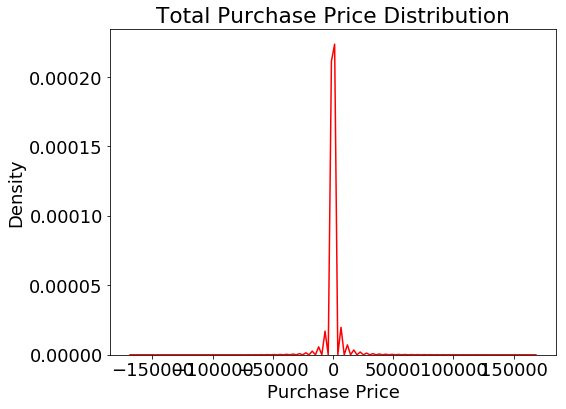

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['font.size'] = 18
from IPython.core.pylabtools import figsize
figsize(8, 6)

# KDE plot of total price
sns.distplot(data['total_price'], hist=False, color = 'red');
plt.title('Total Purchase Price Distribution');
plt.xlabel('Purchase Price'); plt.ylabel('Density');

There appear to be two issues: 1. There are negative purchase prices, and 2. There are extreme outliers on both the upper and lower limit.

The first problem makes sense if we think about the cancellations, which we left in the data. These appear as negative quantities and hence the `total_price` would be negative. However, this is actually not an issue if our goal is to predict total spending. A negative purchase offsets a positive purchase and so even though it might seem odd at first, leaving these cancellations in will allow us to incorporate all of the information about a customer. 

The outliers on both the high and the low end should also be left in because we have no reason to believe these are false. To investigate, we can look at both the highest and lowest total purchases.

In [14]:
data.loc[data['total_price'].idxmax]

order_id                            581483
product_id                           23843
desc           PAPER CRAFT , LITTLE BIRDIE
quantity                             80995
date                   2011-12-09 09:15:00
unit_price                            2.08
customer_id                          16446
country                     United Kingdom
total_price                         168470
Name: 540421, dtype: object

In [15]:
data.loc[data['total_price'].idxmin]

order_id                           C581484
product_id                           23843
desc           PAPER CRAFT , LITTLE BIRDIE
quantity                            -80995
date                   2011-12-09 09:27:00
unit_price                            2.08
customer_id                          16446
country                     United Kingdom
total_price                        -168470
Name: 540422, dtype: object

The highest total purchase price is for an order that was eventualy cancelled (12 minutes later!). This means that for this customer, the total of these two orders would come out to \$0.0. 

The only potential issue with leaving in the cancellations is for the edge cases where the purchase occurred before the cutoff point but the cancellation was after the cutoff point which could mess with the data. However, we'll not worry about this low probability event for the moment.

Now, back to making the prediction problem. The lines below establish a cutoff dataframe that we'll use for building the problem.

In [16]:
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year

data = data[data['date'] < pd.datetime(2011, 12, 1)]
data['date'].max()

Timestamp('2011-11-30 17:42:00')

In [17]:
label_data = data[(data['month'] == 11) & (data['year'] == 2011)]
label_data['date'].describe()

count                   65598
unique                   2747
top       2011-11-14 15:27:00
freq                      543
first     2011-11-01 08:16:00
last      2011-11-30 17:42:00
Name: date, dtype: object

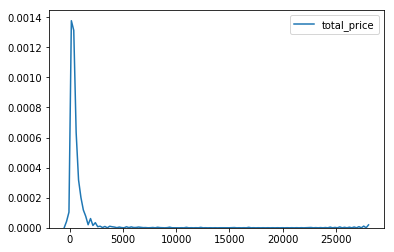

In [18]:
labels = pd.DataFrame(label_data.groupby('customer_id')['total_price'].sum())
sns.kdeplot(labels['total_price'])

Once we have the labels for the customers, we want to make sure to discard any of the data from after the start of November 2011.

In [19]:
data = data[(data['date'] < pd.datetime(2011, 11, 1))]
print('There are {} customers in the training data.'.format(data['customer_id'].nunique()))
data['date'].describe()

There are 4010 customers in the training data.


count                  323570
unique                  16889
top       2011-10-31 14:09:00
freq                      436
first     2010-12-01 08:26:00
last      2011-10-31 17:13:00
Name: date, dtype: object

For any customers that are in the data but are not in the labels, we can set their total purchases to 0.0

In [20]:
labels.index.nunique()

1711

In [21]:
labels.head()

,total_price
customer_id,
12349.0,1757.55
12352.0,311.73
12356.0,58.35
12357.0,6207.67
12362.0,429.09


In [22]:
unique_customers = pd.DataFrame(data['customer_id'].unique()).rename(columns = {0: 'customer_id'})

In [23]:
labels = labels.merge(unique_customers, on = 'customer_id', how = 'right')
labels['total_price'] = labels['total_price'].fillna(0)

Now we need to limit the labels to only contain customers that appear in the data before November 2011.

In [24]:
labels = labels[labels['total_price'] > 0]

print('There are {} unique customers.'.format(labels.index.nunique()))
labels['total_price'].describe()

There are 1338 unique customers.


count    1.338000e+03
mean     7.476355e+02
std      1.754484e+03
min      1.421085e-13
25%      2.374650e+02
50%      3.946450e+02
75%      7.085675e+02
max      2.783745e+04
Name: total_price, dtype: float64

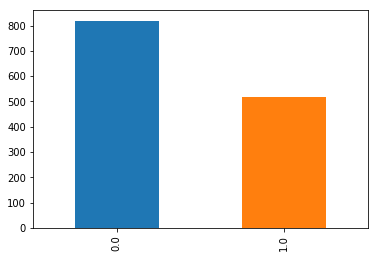

In [25]:
labels = labels.rename(columns = {'total_price': 'target'})
labels['label'] = 1.0 * (labels['target'] > 500)
labels['label'].value_counts().plot.bar()

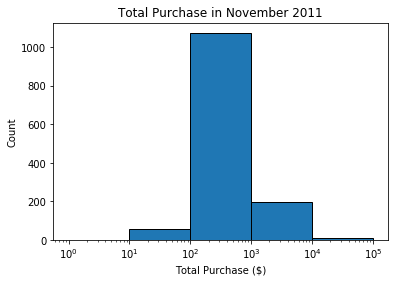

In [26]:
bins = 10**(np.arange(0,5))
p = plt.hist(labels['target'], bins = [1, 10, 100, 100, 1000, 10000, 100000] , 
             edgecolor = 'k')
plt.xscale('log'); plt.xlabel('Total Purchase ($)'); plt.ylabel('Count'); plt.title('Total Purchase in November 2011');

The vast majority of purchases fall in between \$100 and \$1000. We can also view the data with an empirical cumulative distribution function plot.

In [27]:
def ecdf(a):
    x = np.sort(a)
    y = np.arange(len(x)) / float(len(x))
    return x, y

The 90th percentile is at $1283.5400000000004


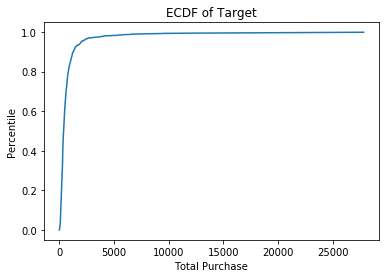

In [28]:
x, y = ecdf(labels['target'])
plt.plot(x, y);
plt.xlabel('Total Purchase'); plt.ylabel('Percentile'); plt.title('ECDF of Target');
print(f'The 90th percentile is at ${x[np.where(y > 0.9)[0][0]]}')

In [29]:
print(f'There are {len(data)} observations in the final data with {data["customer_id"].nunique()} unique customers.')

There are 323570 observations in the final data with 4010 unique customers.


In [30]:
data.to_csv('../input/usable_purchases.csv')

## Train and Test Sets

At this point we want to split the data into training and testing sets and then never look at the testing data until we have to evaluate the final model. We can use a straightforward train/test split with 30% of the data used for testing. We'll split based on the customers.

In [31]:
from sklearn.model_selection import train_test_split

train_customers, test_customers, train_labels, test_labels = train_test_split(list(labels.index), list(labels['label']), 
                                                                             test_size = 0.3, random_state = 50)

print(f'{len(train_customers)} training customers and {len(test_customers)} testing customers.')

936 training customers and 402 testing customers.


# Feature Engineering

We know the data we can use and we have a prediction problem: estimate the amount a customer will spend in the next 30 days. Now we need to get the data into a usable format for a machine learning model to train. Because we are predicting on a customer level basis, this means one table where every row is a customer and the columns are the features for that customer. Right now we have 0 features per customer but plenty of data of their past purchases. We can use the purchase data to create features, such as the total previous amount spent, or the most popular day of the week on which they make purchases.

Feature engineering refers to this process of making features for a machine learning model out of a dataset. The next section of this notebook will be an implementation of all the steps required for manual feature engineering. This requires building each feature one at a time, relying on domain knowledge to construct predictors that are relevant to the domain. This can be a tedious, time-consuming, error-prone process, and is not transferable between problems because the features are very specific. In a later notebook, we will see a more efficient approach, automated feature engineering using Featuretools. 

### Adding More Information

One of the simplest feature engineering steps is to extract information from the original data such as by finding the `weekday`, `month`, `hour`, and `minute` of the purchase.

In [32]:
data['weekday'] = data['date'].dt.weekday
data['month'] = data['date'].dt.month
data['minute'] = data['date'].dt.minute
data['hour'] = data['date'].dt.hour
data['date_only'] = data['date'].dt.date

data.head()

,order_id,product_id,desc,quantity,date,unit_price,customer_id,country,total_price,month,year,weekday,minute,hour,date_only
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,12,2010,2,26,8,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,2010,2,26,8,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,12,2010,2,26,8,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,2010,2,26,8,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,2010,2,26,8,2010-12-01


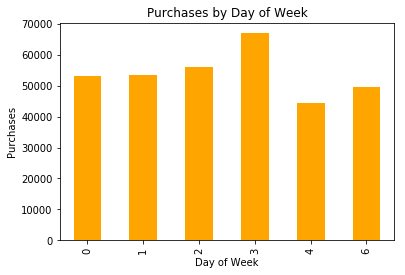

In [33]:
data['weekday'].value_counts().sort_index().plot.bar(color = 'orange');
plt.title('Purchases by Day of Week'); plt.ylabel('Purchases'); plt.xlabel('Day of Week');

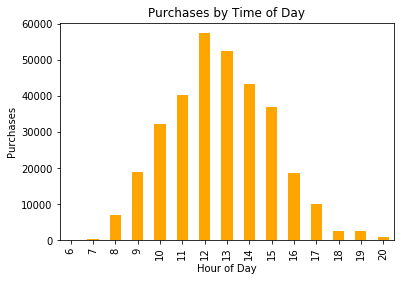

In [34]:
data['hour'].value_counts().sort_index().plot.bar(color = 'orange');
plt.title('Purchases by Time of Day'); plt.ylabel('Purchases'); plt.xlabel('Hour of Day');

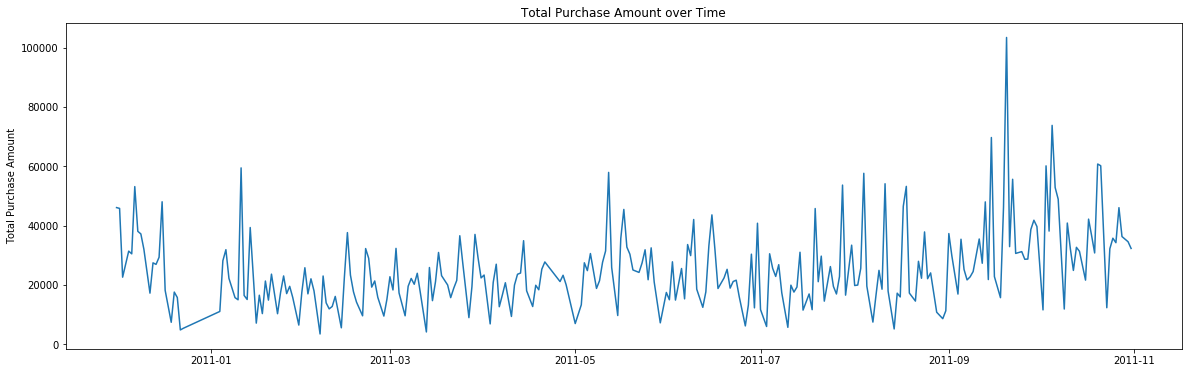

In [35]:
figsize(20, 6)
trends = data.groupby('date_only')['total_price'].sum()
trends.plot()
plt.title('Total Purchase Amount over Time'); plt.xlabel(''); plt.ylabel('Total Purchase Amount');

## Normalizing Data

The first step we need to take is take the one table and break it into discrete normalized tables. We'll create 4 tables of information:

* customers: each customer (`customter_id`) will have one row
* products: each product (`product_id`) will have one row
* orders: each invoice (`order_id`) will have one row
* purchases: each purchased item will have one row

The purchases dataframe is the child of all the other dataframes. The `customers` dataframe is where we will make our features for the prediction problem. Hence to make features, we will have to aggregate the purchase data for each customer. Let's start by breaking the data into multiple dataframes.

### Orders

First we'll create a table of just the orders. Each order is uniquely identified by the `order_id` and also has a date, customer, and country. We can also add a `total_price` for the order by summing up all of the products associated with that order.

In [36]:
orders = pd.DataFrame(data.groupby(['order_id', 'date', 'customer_id', 'country'])['total_price'].sum().reset_index())
orders.head()

,order_id,date,customer_id,country,total_price
0,536365,2010-12-01 08:26:00,17850.0,United Kingdom,139.12
1,536366,2010-12-01 08:28:00,17850.0,United Kingdom,22.20
2,536367,2010-12-01 08:34:00,13047.0,United Kingdom,278.73
3,536368,2010-12-01 08:34:00,13047.0,United Kingdom,70.05
4,536369,2010-12-01 08:35:00,13047.0,United Kingdom,17.85


We should make sure that this table is normalized by checking that there are no duplicated order ids.

In [37]:
print(f'There are {orders["order_id"].nunique()} unique orders and {np.sum(orders["order_id"].duplicated())} duplicated orders.')

There are 18183 unique orders and 29 duplicated orders.


This tells us we made an error in creating the table.

In [38]:
orders[orders.duplicated(subset = 'order_id', keep = False)].head()

,order_id,date,customer_id,country,total_price
116,536591,2010-12-01 16:57:00,14606.0,United Kingdom,159.26
117,536591,2010-12-01 16:58:00,14606.0,United Kingdom,39.06
1471,540185,2011-01-05 13:40:00,14653.0,United Kingdom,212.15
1472,540185,2011-01-05 13:41:00,14653.0,United Kingdom,132.66
1966,541596,2011-01-19 16:18:00,17602.0,United Kingdom,185.92


The problem is that orders do not all have the same date. Therefore when we made the orders table, we should not have grouped by the date time. However, we can group by just the `date_only` and see if all orders are made on the same day. 

In [39]:
orders = pd.DataFrame(data.groupby(['order_id', 'date_only', 'customer_id', 'country'])['total_price'].sum().reset_index())
print(f'There are {orders["order_id"].nunique()} unique orders and {np.sum(orders["order_id"].duplicated())} duplicated orders.')

There are 18183 unique orders and 0 duplicated orders.


Now we are good to go without the duplicated orders. We can use this table to create features, for example by finding the total number of orders of each customer or the most common day on which they make purchases.

### Customers

Each customer is uniquely identified by the `customer_id`. This table will be where we make all the features since we are predicting based on each customer.

In [43]:
len(labels)

1338

In [40]:
customers = pd.DataFrame(labels.index.unique())
customers.head()

,0
0,0
1,1
2,2
3,3
4,4


### Products

Each product is identified by the `product_id`. The unit price might not stay the same so we cannot associate this with each product.

In [42]:
products = pd.DataFrame(data['product_id'].unique(), columns = ['product_id'])
products.head()

,product_id
0,85123A
1,71053
2,84406B
3,84029G
4,84029E


### Purchases

Each purchase is idenitifed by combination of the `order_id`, the `customer_id`, and the `product_id`. The purchases data is already saved as the data table.

In [ ]:
purchases = data.copy()

# Baselines

Before we get started with the real feature engineering and modeling, we should establish a naive baseline model. This will let us measure the effectiveness of any feature engineering. For a regression problem, a naive baseline can be simply the average value of the train labels. 

## Metric 

Since this is a regression problem dealing with a quantity that has a real meaning, we want to use a metric that is easily understandable. The __Median Absolute Error__ (MAE) for this problem shows the median dollar amount that our forecasts are off. This can be calculated as simply the median of the absolute value of the prediction minus the true value:

$$\text{MAE} = \text{median(abs(prediction - true value))}$$

The median absolute error is a better metric than the mean absolute error since the mean will be unduly influenced by outliers (and we saw that there are a number of outliers in the target).

### Naive Baseline

Below we establish a naive baseline by guessing the value of the test label is the average value on the training labels.

In [ ]:
from sklearn.metrics import f1_score

print(f'Baseline Guess F1 Score = {f1_score(test_labels, [0 for _ in range(len(test_labels))])}.') 

In [ ]:
f1_score(test_labels, [np.random.randint(0, 2, 1)[0] for _ in range(len(test_labels))])

### More Informed Baseline

A slightly better estimate would be to guess that customers will spend as much in the next month as they spent in the previous month. We can figure this out by using the last thirty days of the purchase data.

In [ ]:
thirty_day_totals = []
prediction_point = pd.datetime(2011, 10, 1)

# Iterate through each customer
for customer_id, customer_info in labels.iterrows():
    
    # Subset the data to after the prediction point
    subset = data.loc[(data['date'] > prediction_point) & (data['customer_id'] == customer_id), :].copy()
    
    # Add the number of unique orders in the month to a list
    thirty_day_totals.append(subset['total_price'].sum())

In [ ]:
sns.kdeplot(thirty_day_totals)

In [ ]:
customers['label'] = list(labels['label'])
customers['informed_guess'] = thirty_day_totals
customers['informed_guess_label'] = 1.0 * (customers['informed_guess'] > 500)
customers['test'] = customers['customer_id'].isin(test_customers)
customers.head()

In [ ]:
print(f'Informed Baseline F1 Score: {round(f1_score(test_labels, list(customers.loc[customers["test"] == True, "informed_guess_label"])), 2)}')

The informed baseline significantly outperformed the naive baseline. Now we know that if we can't predict with a median absolute error less than around \$288, then maybe machine learning is not applicable to this problem.

# Feature Engineering Implementation

After we established our baseline, we can start making features for a machine learning model to learn the problem. In manual feature engineering, we build features one at a time. We can constantly evaluate these features using cross-validation on the training set. 

## Building Features from Previous Orders

The first set of features will be built on the previous orders. We can find the __total__ number of a customers previous orders, the __total value__ of a customers previous orders, and then also divide both of these by the time between the __first order and last order__ in order to get an orders / time feature.

Below we find the total orders and total value of orders for customers.

In [ ]:
total_orders = orders.groupby('customer_id')['order_id'].count()
total_value_orders = orders.groupby('customer_id')['total_price'].sum()
totals = pd.concat([total_orders, total_value_orders], axis = 1).rename(columns = {'order_id': 'num_orders',
                                                                                   'total_price': 'total_spending'})
totals.head()

In [ ]:
figsize(8, 6)
sns.lmplot('num_orders', 'total_spending', data = totals, size = 6)
plt.title('Total Spending versus Number of Orders');

For the time a customer has been in the records, we'll take the last order data minus the first order date and convert it to the number of months. Then we can divide the `num_orders` and `total_spending` by this figure to arrive at a final ratio per 30 days.

In [ ]:
# Find timedelta between last and first order
totals['record_length'] = orders.groupby('customer_id')['date_only'].apply(lambda x: x.max() - x.min())

# Convert to 30 days
totals['record_length'] = totals['record_length'].dt.total_seconds() / (3600 * 24 * 30)

# Get ratios
totals['num_orders_ratio'] = totals['num_orders'] / totals['record_length']
totals['spending_ratio'] = totals['total_spending'] / totals['record_length']
totals.head()

Let's try to intrepret these numbers: what the `spending_ratio` indicates is the total spending for every 30 days, and the `num_orders_ratio` is the number of orders on average every 30 days. 

We'll replace the `inf` with `np.nan` which later will let us impute these values before sending the data to a machine learning model.

In [ ]:
totals = totals.replace({np.inf: np.nan, -np.inf: np.nan})

sns.violinplot(y = totals['spending_ratio'].dropna());
plt.title('Violin Plot of Spending Ratio');

In [ ]:
totals.loc[totals['spending_ratio'].idxmax]

The highest spending in the data is from a customer that averages over \$10000 per month, because they are have been in the data for less than one month yet have a total spending of \$8000. As a final feature, we can calculate the spending per order.

In [ ]:
totals['spending_per_order'] = totals['total_spending'] / totals['num_orders']
sns.kdeplot(totals['spending_per_order'])
plt.title('Spending per Order Distribution');

### Evaluate Feature Set

From just these 5 features we can already train a model (we only need a single feature to train a model). We'll use a random forest regressor as implemented in the `utils.py` module and the `evaulate` function. 

In [ ]:
%load_ext autoreload
%autoreload 2

from utils import evaluate, plot_feature_importances, feature_selection

In [ ]:
totals = totals[(totals.index.isin(train_customers)) | (totals.index.isin(test_customers))]
totals.head()

In [ ]:
train = totals[totals.index.isin(train_customers)]
test = totals[totals.index.isin(test_customers)]

In [ ]:
preds, fi = evaluate(train, train_labels, test, test_labels)

Already our model has outperformed the baseline! This means machine learning is applicable to the problem. To improve our performance, we want to keep adding more features derived from the data. We can use the feature importances from the first model to see which features are considered most relevant.

In [ ]:
norm_fi = plot_feature_importances(fi)

In [ ]:
train['target'] = train_labels
train.to_csv('../input/train_features.csv')
test['target'] = test_labels
test.to_csv('../input/test_features.csv')

The most important feature is the `total_spending`. This tells us that how much a customer has spent total in the past is indicative of the amount they will spend in the next 30 days. 

### More Features from the Order Table

We'll continue with feature engineering using the orders table. We'll make an additional 4 features:

* Spending in the last 30 days of data
* Number of orders in the last 30 days of data
* Spending per order in the last 30 days of data
* Most common country ordered from
* Number of unique countries ordered from

Although the baseline guess using the spending in the previous 30 days did not prove helpful, perhaps it will be of some use to a machine learning model. Since the spending per order was an important feature, we also will want to calculate the spending per order in the past 30 days. This shows the iterative process of feature engineering: we can use previous results to inform future decisions.

In [ ]:
thirty_day_orders = []
thirty_day_totals = []

prediction_point = pd.datetime(2011, 10, 1)

for customer_id, customer_info in labels.iterrows():
    
    # Subset to the last thirty days
    subset = orders[(orders['customer_id'] == customer_id) & (orders['date_only'] > prediction_point.date())].copy()
    thirty_day_orders.append(subset.shape[0])
    thirty_day_totals.append(subset['total_price'].sum())

In [ ]:
totals['thirty_day_orders'] = thirty_day_orders
totals['thirty_day_totals'] = thirty_day_totals
totals['thirty_day_spending_per_order'] = totals['thirty_day_totals'] / totals['thirty_day_orders']

plt.figure(figsize = (12, 6))
sns.kdeplot(totals['thirty_day_spending_per_order']);
plt.title('Thirty Day Spending per Order Distribution');

Again we see a positively skewed distribution with most customers spending per order below \$1000 in the previous 30 days, but a few customers with spending per order much higher. 

The next two features will deal with the `country` of the order.

In [ ]:
unique_countries = orders.groupby('customer_id')['country'].nunique()
most_common_country = orders.groupby('customer_id')['country'].apply(lambda x: pd.Series.mode(x)[0])

totals['num_unique_countries'] = unique_countries
totals['most_common_country'] = most_common_country

In [ ]:
plt.figure(figsize = (16, 6))
g = sns.boxplot(x = 'most_common_country', y = 'thirty_day_spending_per_order', data = totals)
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=75)
plt.title('Thirty Day Spending per Order by Country');

Now we have to one-hot encode the country in order to pass it into the model.

In [ ]:
totals = pd.get_dummies(totals)
totals.head()

Let's evaluate this model to see if the 5 (more if we count the one-hot encoding) extra features improved the performance.

In [ ]:
train = totals[totals.index.isin(train_customers)]
test = totals[totals.index.isin(test_customers)]

preds, fi = evaluate(train, train_labels, test, test_labels)

In [ ]:
norm_fi = plot_feature_importances(fi)

Including the new features did not improve the model even though the most important feature was one of those that we added. It looks like the country feature are not important. Most of the customers (~90%) are from the United Kingdom so there is not much information content in the country of the order.

At this point we have extracted a lot of information from the `orders` table, but there is plenty more that we did not consider such as using the day of week, the month of year, or creating country level features and then applying these to each customer. With manual feature engineering, __we are limited by our time and creativity__. There are only so many features that we can make by hand, one of the fundamental issues with the traditional approach to feature engineering. 

### Features from the Purchase Data

Next we'll work of building features from the purchase level data. This gives us more granular information than the `orders` and presents us with even more potential features to make. We'll start off by finding the total number of purchases, the sum of purchases (which should be the same as that from the orders) and the ratios of these per 30 day period, much as we did with the orders.

In [ ]:
total_purchases = purchases.groupby('customer_id')['order_id'].count()
total_value_purchases = purchases.groupby('customer_id')['total_price'].sum()
total_purchases = pd.concat([total_purchases, total_value_purchases], axis = 1).rename(columns = {'order_id': 'num_purchases',
                                                                                                  'total_price': 'total_purchase_spending'})
total_purchases.head()

In [ ]:
# Find timedelta between last and first order
total_purchases['record_length'] = purchases.groupby('customer_id')['date'].apply(lambda x: x.max() - x.min())

# Convert to 30 days
total_purchases['record_length'] = total_purchases['record_length'].dt.total_seconds() / (3600 * 24 *  30)

# Get ratios
total_purchases['num_purchases_ratio'] = total_purchases['num_purchases'] / total_purchases['record_length']
total_purchases['spending_ratio'] = total_purchases['total_purchase_spending'] / total_purchases['record_length']
total_purchases = total_purchases.replace({np.inf: np.nan, -np.inf: np.nan})

sns.violinplot(y = total_purchases['num_purchases'])
plt.title('Number of Purchases');

In [ ]:
sns.lmplot('record_length', 'num_purchases', data = total_purchases, size = 8);
plt.title('Number of Purchases vs 30 Day Periods');

In [ ]:
totals = totals.merge(total_purchases, on = 'customer_id')
totals.shape

In [ ]:
train = totals[totals.index.isin(train_customers)]
test = totals[totals.index.isin(test_customers)]

preds, fi = evaluate(train, train_labels, test, test_labels)

Our model performance has now decreased significantly. One issue is that we could have too many features: some of the features could be correlated with one another which can lead to worse performance. We can use the `feature_selection` function from `utils.py` to remove potentially problematic features. 

In [ ]:
train = feature_selection(train, missing_threshold=90, correlation_threshold=0.9)
test = test[train.columns]

In [ ]:
train.shape

In [ ]:
preds, fi = evaluate(train, train_labels, test, test_labels)

Feature selection did not help which is somewhat surprising. It's possible that we accidentally removed some features that were critical to the model. Let's try one last round of feature engineering. We'll load back in the features that have performed the best and try to add some more information.

In [ ]:
train = pd.read_csv('../input/train_features.csv')
test = pd.read_csv('../input/test_features.csv')

train.head()

In [ ]:
train.corr()

## Last Round of Feature Engineering 

For the last round of feature engineering we'll focus on

In [ ]:
total_purchases.head()

In [ ]:
orders.head()

The second baseline will be made by applying a Random Forest Regressor to 

In [ ]:
import seaborn as sns

data['total_price'] = (data['quantity'] * data['unit_price']).astype(np.float32)
sns.kdeplot(data['total_price']);

In [ ]:
data['total_price'].describe()

There are several negative total prices which are not physically possible. If we look at the original data, this is because there are several orders that were cancelled (identifed by a 'C' preceding the order id). To handle these, we'll remove the cancelled lines themselves but add a flag indicating the order was cancelled.  

In [ ]:
data['order_id'] = data['order_id'].astype(str)
cancelled_order_ids = [x[1:] for x in data['order_id'] if x.startswith('C')]
len(cancelled_order_ids)

In [ ]:
data['cancelled'] = data['order_id'].isin(cancelled_order_ids)
data.shape

In [ ]:
data = data[~data['order_id'].str.startswith('C')]
data.shape

Now we'll set to 0 any of the total value where the order was cancelled.

In [ ]:
data.loc[data['cancelled'], 'total_price'] = np.nan
sns.kdeplot(data['total_price'])

The cancelled orders are not duplicated in the orders table but are instead identified by a 'C' in front of the order id. We'll add a flag indicating if the order was cancelled. 

In [ ]:
orders['order_id'] = orders['order_id'].astype(str)

In [ ]:
orders['cancelled'] = orders['order_id'].str.startswith('C')
orders['cancelled'].value_counts()

To make a feature for customers, we can count the number of cancelled orders and the number of non-cancelled orders.

In [ ]:
cancelled = pd.DataFrame(orders.groupby('customer_id')['cancelled'].sum())
total = pd.DataFrame(orders.groupby('customer_id')['cancelled'].count()).rename(columns = {'cancelled': 'total'})
customer_orders = cancelled.merge(total, on = 'customer_id')
customer_orders['non_cancelled'] = customer_orders['total'] - customer_orders['cancelled']
customer_orders.head()

In [ ]:
customer_orders.describe()

We can try to build a model from just this information and see if it is at all useful! 

In [ ]:
customers.head()

In [ ]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(customer_orders, customers['label'],
                                        stratify = customers['label'])

In [ ]:
from sklearn.metrics import f1_score, make_scorer

scorer = make_scorer(f1_score, average = 'weighted')

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier()
model.fit(X, y)

In [ ]:
lengths = data.groupby('customer_id')['date'].apply(lambda x: x.max() - x.min())

In [ ]:
lengths.describe()

In [ ]:
cross_val_score(model, X, y, scoring = scorer, cv = 5)

In [ ]:
model.feature_importances_

In [ ]:
preds

In [ ]:
X_test

In [ ]:
preds = model.predict(X_test)
f1_score(y_test, preds)

In [ ]:
x, y = ecdf(data['total_price'])
plt.plot(x, y)

In [ ]:
data.loc[(data['total_price'] < 0) | (data['total_price'] > 10000), 'total_price'] = np.nan
sns.kdeplot(data['total_price']);

In [ ]:
data['weekday'] = data['date'].dt.weekday
data['month'] = data['date'].dt.month
data['minute'] = data['date'].dt.minute
data['hour'] = data['date'].dt.hour

data.head()

Now we can start making features for each customer. As an example, we can count the number of previous orders by the customer. Then, we can divide the number of previous orders by the date between the first and last occurrence of the customer in the data to come up with a rate of purchases. 

In [ ]:
date_limits = usable_data

In [ ]:
orders = orders.merge(data, on = 'order_id', how = 'left'a
                     )
orders.head()

In [ ]:
ft_data = ft.demo.load_retail()
ft_data